# 导包

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
from PIL import Image
from pyecharts.charts import Pie
from pyecharts import options as opts
%matplotlib inline
pd.set_option("display.max_column",None)
sns.set_style('white',{'font.sans-serif':['simhei','Arial']})

from pyecharts.globals import CurrentConfig, NotebookType
# 配置对应的环境类型
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
CurrentConfig.ONLINE_HOST='https://assets.pyecharts.org/assets/'

# 常规赛数据

In [2]:
df_season = pd.read_pickle("season.pkl")

In [3]:
df_season.rename(columns={"出手":"总出手","命中":"总命中","命中.1":"三分命中","出手.1":"三分出手","命中.2":"罚球命中","出手.2":"罚球出手"},
                inplace=True)

In [4]:
df_season.head()

,球员,赛季,果,比赛,首发,时间,投篮,总命中,总出手,三分,三分命中,三分出手,罚球,罚球命中,罚球出手,篮板,前场,后场,助攻,抢断,盖帽,失误,犯规,得分,type
1,迈克尔-乔丹,89-90,胜,骑士113-117公牛,1,50,62.2%,23,37,33.3%,2,6,91.3%,21,23,18,7,11,6,4,1,2,5,69,常规赛
2,迈克尔-乔丹,92-93,负,魔术128-124公牛,1,47,55.1%,27,49,20.0%,1,5,81.8%,9,11,6,4,2,1,5,0,2,5,64,常规赛
3,迈克尔-乔丹,86-87,胜,活塞120-125公牛,1,43,56.4%,22,39,NaN,0,0,94.4%,17,18,7,3,4,3,3,3,5,0,61,常规赛
4,迈克尔-乔丹,86-87,负,老鹰117-114公牛,1,41,57.9%,22,38,0.0%,0,3,81.0%,17,21,10,5,5,1,4,1,3,3,61,常规赛
5,迈克尔-乔丹,87-88,胜,活塞110-112公牛,1,42,77.8%,21,27,0.0%,0,1,89.5%,17,19,4,2,2,6,2,2,1,4,59,常规赛


## 各个赛季的场均得分以及胜率

In [5]:
season = list(np.sort(df_season["赛季"].unique()))
season = season[2:] + season[:2]

In [6]:
df_season["win"] = df_season["果"].map({"胜": 1, "负": 0})
wining_rate = df_season.groupby(["赛季"])["win"].mean()[season].values

Text(0, 0.5, '胜率')

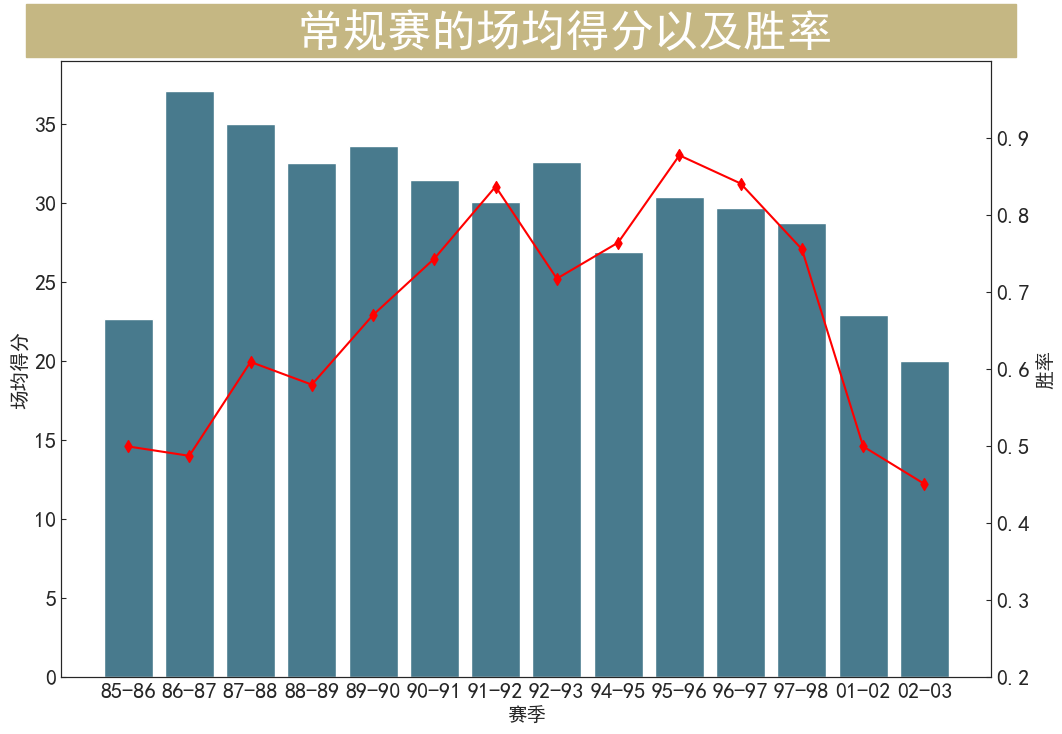

In [7]:
fig,ax = plt.subplots(figsize=(12,8))
fig.text(x=0.1, y=0.9, s='            常规赛的场均得分以及胜率        ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
sns.barplot(x="赛季",y="得分",data=df_season,order=season,errorbar=None,color="#3c7f99")
plt.tick_params(labelsize=16,axis="both",direction="in")
plt.ylabel("场均得分",fontsize=14)
plt.xlabel("赛季",fontsize=14)
ax2=ax.twinx()
plt.scatter(x=season,y=wining_rate,color="r",marker='d')
plt.plot(season,wining_rate,color="r")
plt.tick_params(labelsize=16,axis="both",direction="in")
ax2.set_yticks([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
plt.ylim(0.2,1)
plt.ylabel("胜率",fontsize=14)

## 单场比赛各个得分段占比

In [8]:
interval = ["20分及以下","20-30","30-40","40-50","大于50"]
value = pd.cut(df_season["得分"],bins=[0,20,30,40,50,100],labels=interval).value_counts(normalize=True)[interval].values

In [9]:
pie = (
    Pie()
    .add(
        "",
        [list(z) for z in zip(interval, value)],
        center=["50%", "50%"],
       # radius=["50%","75%"]
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="单场比赛各个得分段占比",pos_left="center"),
        legend_opts=opts.LegendOpts(
                is_show=False
            )
    )
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%")))

In [10]:
pie.render_notebook()

## 乔丹的进攻偏好

In [11]:
df_season["两分出手"] = df_season["总出手"]-df_season["三分出手"]

In [12]:
two_point_select= df_season["两分出手"].sum()/df_season["总出手"].sum()
three_point_select = 1-two_point_select
two_point_ratio = (df_season["得分"]-df_season["三分命中"]*3-df_season["罚球命中"]).sum()/df_season["得分"].sum()
free_throw_ratio = df_season["罚球命中"].sum()/df_season["得分"].sum()
three_point_ratio = 1-two_point_ratio-free_throw_ratio 

In [13]:
pie = (
    Pie()
     .add(
        "",
        [("两分球",two_point_ratio),("三分球",three_point_ratio),("罚球",free_throw_ratio)],
        #[list(z) for z in zip(education.index, np.round(education.values,4))],
        center=["33%", "50%"],
        radius=["50%","75%"]
    )
    .add(
        "",
        [("两分出手",two_point_select),("三分出手",three_point_select)],
        #[list(z) for z in zip(education.index, np.round(education.values,4))],
        center=["78%", "50%"],
        radius=["50%","75%"]
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(title="得分来源占比（左）和出手选择占比（右）",pos_left="35%"),
        legend_opts=opts.LegendOpts(
                is_show=False
            )
    
    )
   
    .set_series_opts(label_opts=opts.LabelOpts(formatter="{b}: {d}%")))

In [14]:
pie.render_notebook()

## 生涯对各个球队的对战情况（场均得分、胜率）柱状图

In [15]:
pattern = re.compile(r'[\u4E00-\u9FA5]+')
df_season["team_list"] = df_season["比赛"].str.findall(pattern).map(set)

In [16]:
def get_opp(x,num=0):
    period_dict = {0:"公牛",1:"奇才"}
    opp = (x-set([period_dict[num]])).pop()
    if opp == "人":
        return "76人"
    elif opp == "凯尔特":
        return "凯尔特人"
    elif opp == "超音速":
        return "雷霆"
    elif opp == "子弹":
        return "奇才"
    else:
        return opp
df_season.loc[~df_season["赛季"].isin(["01-02","02-03"]),"opp"] = df_season["team_list"].map(lambda x : get_opp(x,0))
df_season.loc[df_season["赛季"].isin(["01-02","02-03"]),"opp"] = df_season["team_list"].map(lambda x : get_opp(x,1))

Text(0, 0.5, '')

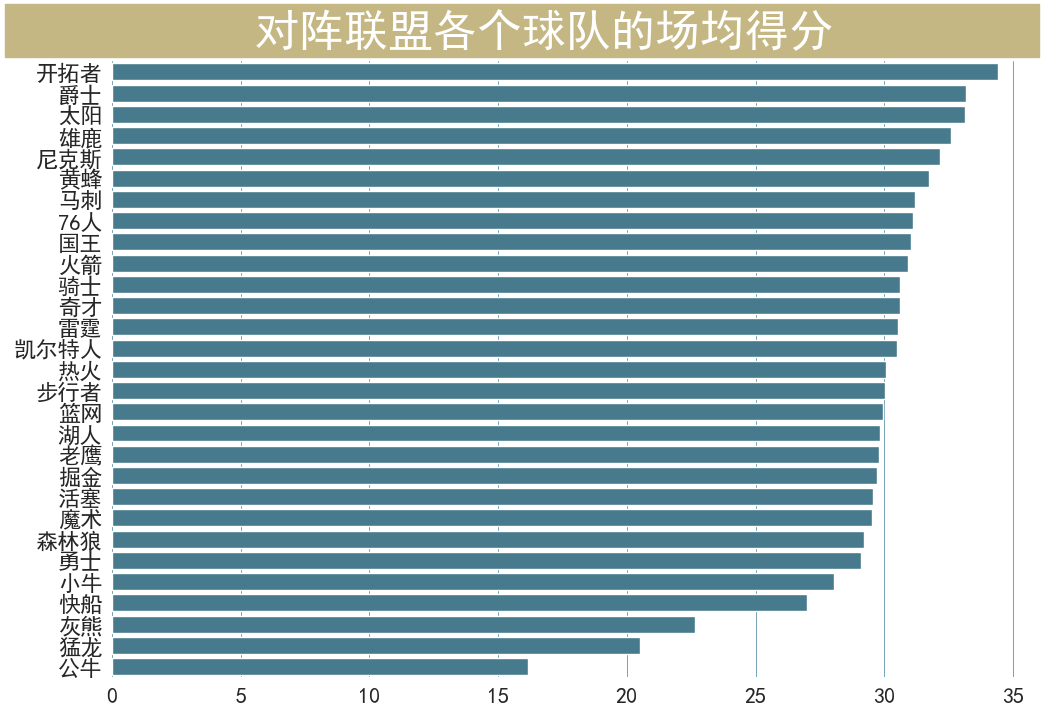

In [17]:
fig, ax = plt.subplots(figsize=(12,8))
order = df_season.groupby("opp")["得分"].mean().sort_values(ascending=False).index
sns.barplot(y="opp",x = "得分",order=order,data=df_season,color='#3c7f99',errorbar=None)
plt.box(False)
fig.text(x=0.04, y=0.90, s='           对阵联盟各个球队的场均得分         ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
plt.xlabel('')
plt.ylabel('')

Text(0, 0.5, '')

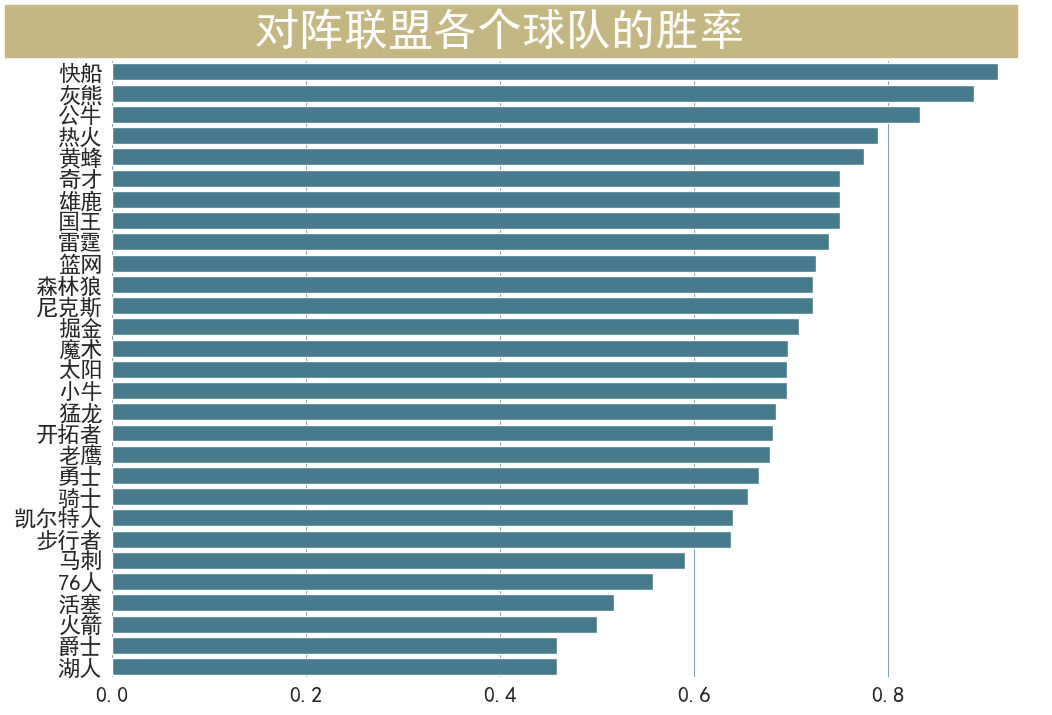

In [18]:
fig, ax = plt.subplots(figsize=(12,8))
order = df_season.groupby("opp")["win"].mean().sort_values(ascending=False).index
sns.barplot(y="opp",x = "win",order=order,data=df_season,color='#3c7f99',errorbar=None)
plt.box(False)
fig.text(x=0.04, y=0.90, s='           对阵联盟各个球队的胜率            ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#c5b783')
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.5, color='#3c7f99')
# plt.xticks([0.2,0.4,0.6,0.8,1.0])
plt.xlabel('')
plt.ylabel('')

## 常规赛胜负的分差状况

In [19]:
pattern = re.compile("(\d+)-(\d+)")
df_season["diff"] = df_season["比赛"].str.findall(pattern).map(lambda x : np.abs(int(x[0][0])-int(x[0][1])))

Text(120.72222222222221, 0.5, '比赛结果')

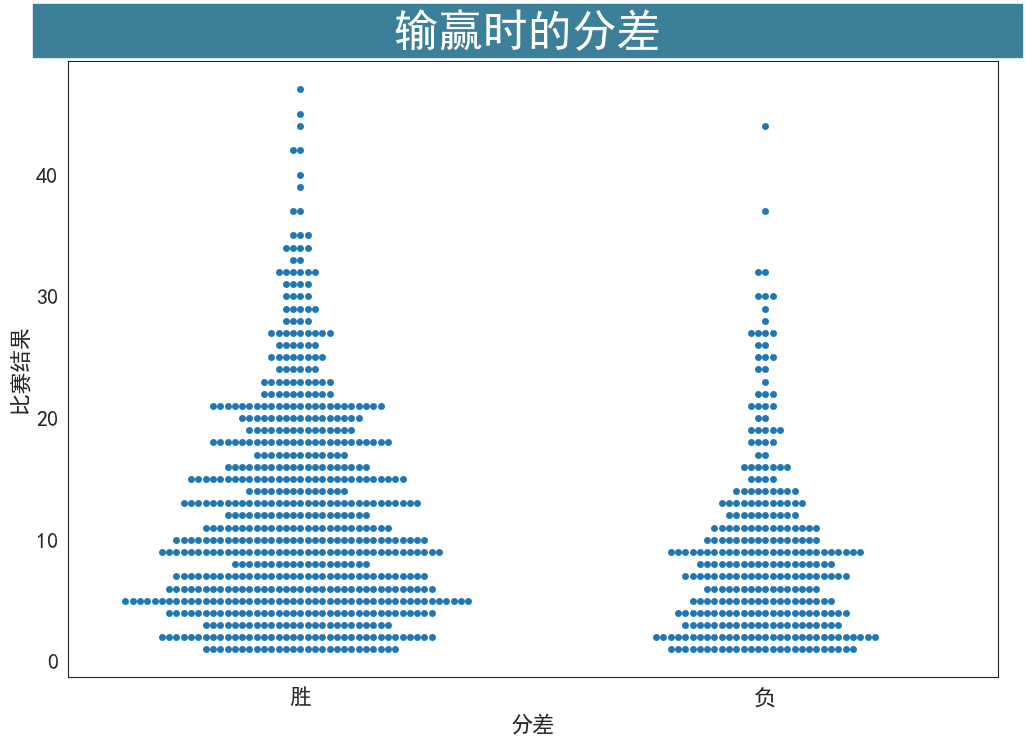

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
sns.swarmplot(x="果",y="diff",data=df_season) 
fig.text(x=0.1, y=0.90, s='                输赢时的分差                ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#3c7f99')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel("分差",fontsize=16)
plt.ylabel("比赛结果",fontsize=16)

# 季后赛数据分析

In [21]:
df_playoff = pd.read_excel("playoff.xls")

## 乔丹的季后赛之路

In [22]:
df_playoff["win"] = df_playoff["果"].map({"胜":1,"负":0})

In [23]:
pattern = re.compile(r'[\u4E00-\u9FA5]+')
df_playoff["team_list"] = df_playoff["比赛"].str.findall(pattern).map(set)
df_playoff.loc[:,"opp"] = df_playoff["team_list"].map(lambda x : get_opp(x,0))

In [24]:
df_plot = df_playoff.groupby(["赛季","轮次","opp"])["win"].mean().reset_index()

In [25]:
season_dict = dict(zip(df_plot["赛季"].unique(),[i for i in range(12)]))
df_plot["season"] = df_plot["赛季"].map(season_dict) 

In [26]:
horizon = [0.11,0.18,0.24,0.30,0.37,0.43,0.50,0.56,0.63,0.69,0.76,0.82]
vertical = [0.13,0.35,0.58,0.79]

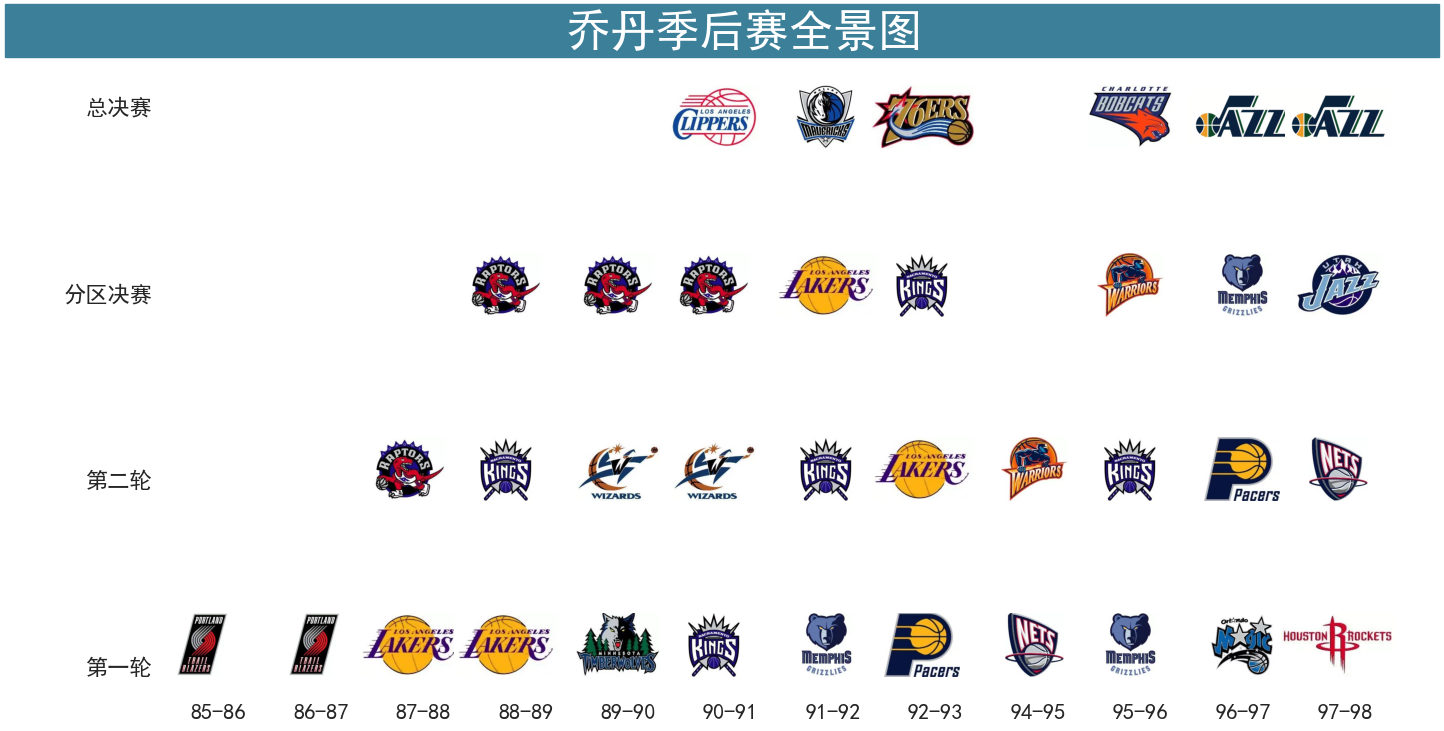

In [27]:
fig, ax = plt.subplots(figsize=(16, 8))
fig.text(x=0.03, y=0.92, s='                         乔丹季后赛全景图                       ', fontsize=32, 
         weight='bold', color='white', backgroundcolor='#3c7f99')
plt.scatter(df_plot["赛季"], df_plot["轮次"], alpha=0.35)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.box(False)
plt.yticks([1,2,3,4],labels=["第一轮","第二轮","分区决赛","总决赛"])
for point in range(len(df_plot)):
    season = df_plot.iloc[point,4]
    round_ = df_plot.iloc[point,1]-1 
    team_name = df_plot.iloc[point,2]
    left,bottom,width,height = horizon[season], vertical[round_],0.08,0.08
    ax2 = fig.add_axes([left,bottom,width,height])
    img = Image.open("./picture/{team_name}.jpg".format(team_name=team_name))
    ax2.imshow(img)
    ax2.axis('off') # 关掉坐标轴为 off

## 季后赛各轮次的输赢分差

In [28]:
pattern = re.compile("(\d+)-(\d+)")
df_playoff["diff"] = df_playoff["比赛"].str.findall(pattern).map(lambda x : np.abs(int(x[0][0])-int(x[0][1])))

In [29]:
color = df_playoff["果"].map({"胜":"#e60000","负":"#73e68c"})

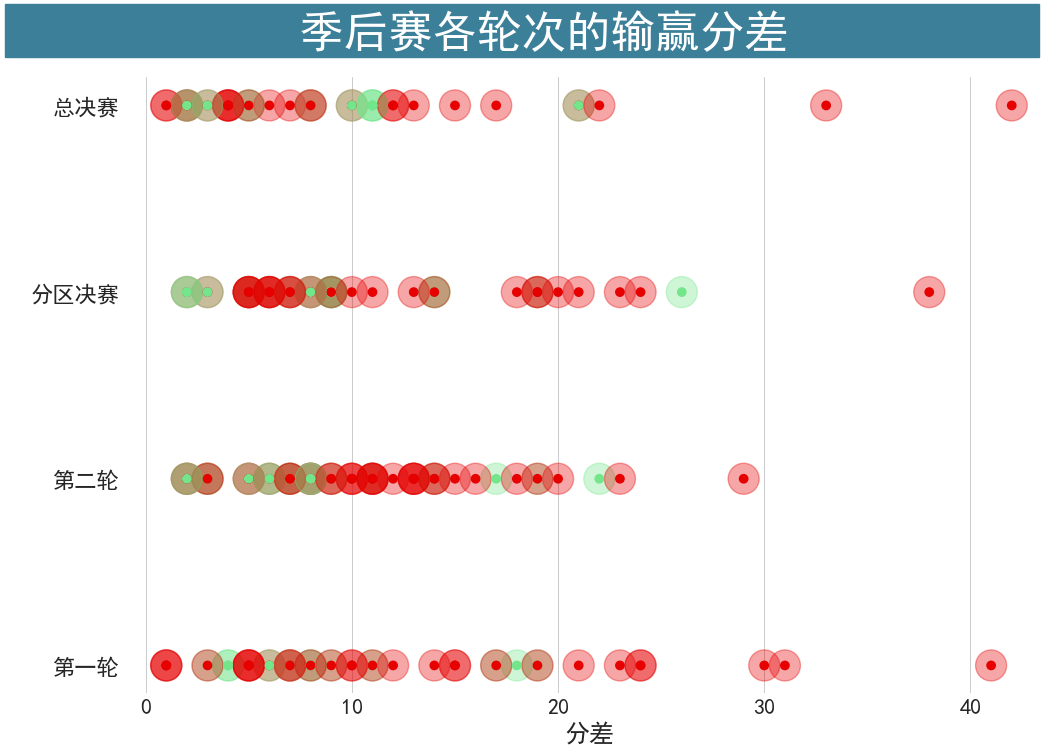

In [30]:
fig, ax = plt.subplots(figsize=(12, 8))
fig.text(x=0.03, y=0.92, s='             季后赛各轮次的输赢分差           ', fontsize=32, 
         weight='bold', color='white', backgroundcolor='#3c7f99')
plt.yticks([1,2,3,4],labels=["第一轮","第二轮","分区决赛","总决赛"])
plt.scatter(df_playoff["diff"], df_playoff["轮次"], alpha=0.35,c=color,s=500)
plt.scatter(df_playoff["diff"], df_playoff["轮次"], c=color)
plt.tick_params(axis='both', which='both', length=0)
plt.tick_params(axis='both', which='major', labelsize=16)
ax.xaxis.grid(which='both', linewidth=0.75)
#plt.xticks(np.arange(0,61,10), [str(i)+"k" for i in range(0,61,10)])
plt.xlabel('分差', fontsize=18)
plt.box(False)
#seed_scale_plot()

## 常规赛和季后赛场均得分对比

In [31]:
season_score = df_season.groupby("赛季")["得分"].mean().values[2:]
playoff_score = df_playoff.groupby("赛季")["得分"].mean().values
index = df_playoff.groupby("赛季")["得分"].mean().index

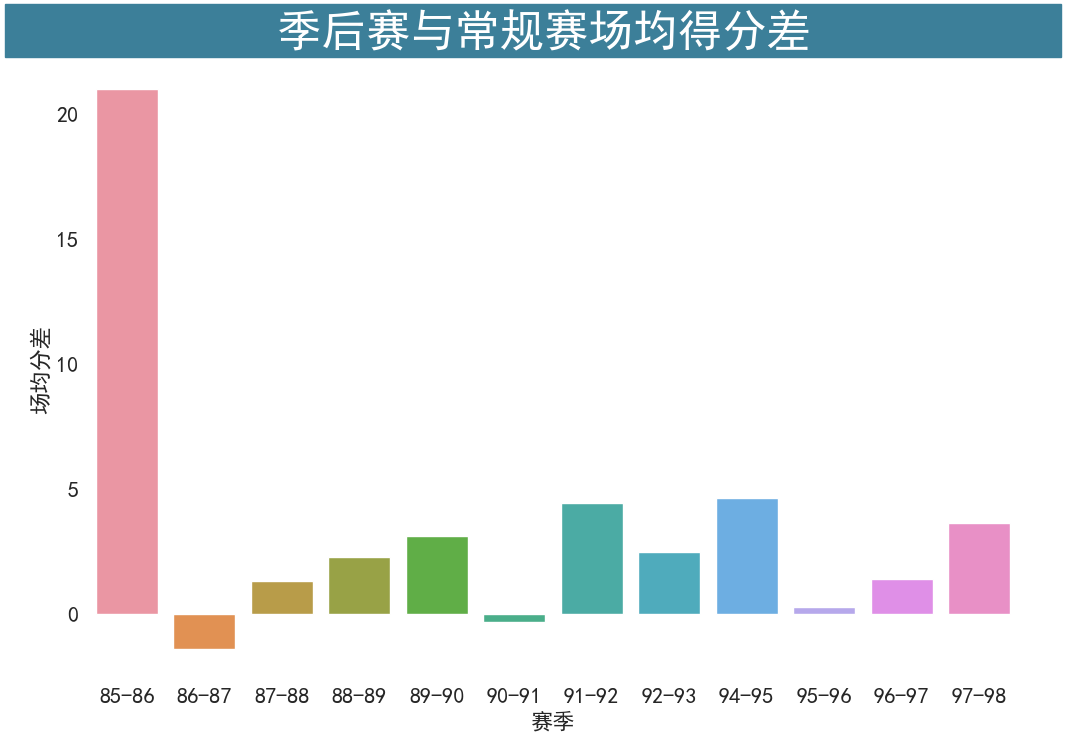

In [32]:
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x=index,y=playoff_score-season_score)
fig.text(x=0.06, y=0.90, s='            季后赛与常规赛场均得分差           ', 
         fontsize=32, weight='bold', color='white', backgroundcolor='#3c7f99')
plt.tick_params(axis='both', which='major', labelsize=16)
plt.xlabel("赛季",fontsize=16)
plt.ylabel("场均分差",fontsize=16)
plt.box(False)